In [ ]:
!pip3 install timm
!pip3 install albumentations

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


Parameters

In [ ]:
import pandas as pd
import albumentations as A
from pathlib import Path
from albumentations.core.composition import Compose, OneOf
from albumentations.pytorch import ToTensorV2

class InferenceParams:
    universe = Path('/work/herbarium-2022/data/train_cultivar_mapping.csv')
    img_size = 512
    model_save = Path('/work/herbarium-2022/trained/ckpt_epoch_36.pth')
    test_dir_path = Path('/work/herbarium-2022/data/test')
    submission_path = Path('/work/herbarium-2022/submission/submission.csv')

    # mean and std of each color channel
    # below is that of imagenet 
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]

    batch_size = 8

IP = InferenceParams

IP.universe = pd.read_csv(Path("/work/herbarium-2022/data/train_cultivar_mapping.csv"))
IP.universe = IP.universe[IP.universe.image != '.DS_Store'] # sanitize inputs and remove the .DS_Store bulls**t

IP.transforms = {
    'train': Compose([
                A.RandomResizedCrop(height=IP.img_size, width=IP.img_size),
                A.Flip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=0.5),
                    A.RandomGamma(p=0.5),
                ], p=0.5),
                A.OneOf([
                    A.Blur(p=0.1),
                    A.GaussianBlur(p=0.1),
                    A.MotionBlur(p=0.1),
                ], p=0.1),
                A.OneOf([
                    A.GaussNoise(p=0.1),
                    A.ISONoise(p=0.1),
                    A.GridDropout(ratio=0.5, p=0.2),
                    A.CoarseDropout(max_holes=16, min_holes=8, max_height=16, max_width=16, min_height=8, min_width=8, p=0.2)
                ], p=0.2),
                A.Normalize(
                    mean=IP.norm_mean,
                    std=IP.norm_std,
                ),
                ToTensorV2(),
            ]),
    
    'test': Compose([
                A.Resize(height=IP.img_size, width=IP.img_size),
                A.Normalize(
                    mean=IP.norm_mean,
                    std=IP.norm_std,
                ),
                ToTensorV2(),
            ])
}

/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is copied from rookie-draft-1.ipynb. We did not write a single source of truth because it's a pain to import custom modules in Kaggle

In [ ]:
import torch
import timm
from torch import nn

class CustomEffNet(nn.Module):
    def __init__(self, model_name='tf_efficientnet_b0_ns', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features
#         self.model.fc = nn.Linear(in_features, CFG.num_classes)
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(in_features, 100)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
model = CustomEffNet(model_name='tf_efficientnet_b3_ns', pretrained=False)
model_state = torch.load(IP.model_save, map_location=torch.device('cpu'))['model']
model.load_state_dict(model_state)
model.eval()

CustomEffNet(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNorm2d(40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_r

In [ ]:
import os
import pandas as pd
import torch
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import convert_image_dtype
import cv2

class CultivarInferenceDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.filelist = [x for x in self.img_dir.iterdir() if not x.is_dir()]
        # print(self.filelist)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx):
        img_path = str(self.filelist[idx])

        name = self.filelist[idx].name

        # NOTE: when pytorch reads an image, it is immediately transformed into a uint8 Tensor with each channel ranging in [0, 255]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)['image']
        
        return name, image

c = CultivarInferenceDataset(IP.test_dir_path, transform=IP.transforms['test'])

# Test to see what the tuple looks like
print(c[0])


('1001197278.png', tensor([[[ 1.9064,  1.9064,  1.9064,  ...,  1.8208,  1.8208,  1.4612],
         [ 2.2489,  2.2318,  1.7865,  ...,  2.2489,  2.2489,  1.7009],
         [ 1.6495,  0.6906, -0.2513,  ...,  2.2489,  2.2489,  1.7009],
         ...,
         [-0.3541, -0.3027, -0.3369,  ..., -0.6281, -0.6623, -0.8507],
         [-0.3369, -0.3712, -0.3198,  ..., -0.6109, -0.6281, -0.8335],
         [-0.4226, -0.4739, -0.4568,  ..., -0.7479, -0.7479, -0.8849]],

        [[ 2.0784,  2.0784,  2.0784,  ...,  2.0784,  2.0784,  1.6583],
         [ 2.4286,  2.4286,  2.2360,  ...,  2.4286,  2.4286,  1.8333],
         [ 2.1134,  1.3606,  0.2052,  ...,  2.4286,  2.4286,  1.8683],
         ...,
         [-0.0399, -0.0224, -0.0224,  ..., -0.3725, -0.3550, -0.3375],
         [-0.0399, -0.0049, -0.0049,  ..., -0.3550, -0.3375, -0.3725],
         [ 0.0301,  0.0301, -0.0049,  ..., -0.3901, -0.3550, -0.3725]],

        [[ 1.5768,  2.1520,  2.2914,  ...,  0.8797,  0.9668,  0.5485],
         [ 2.1346,  2.6226

Check to make sure the dataset works

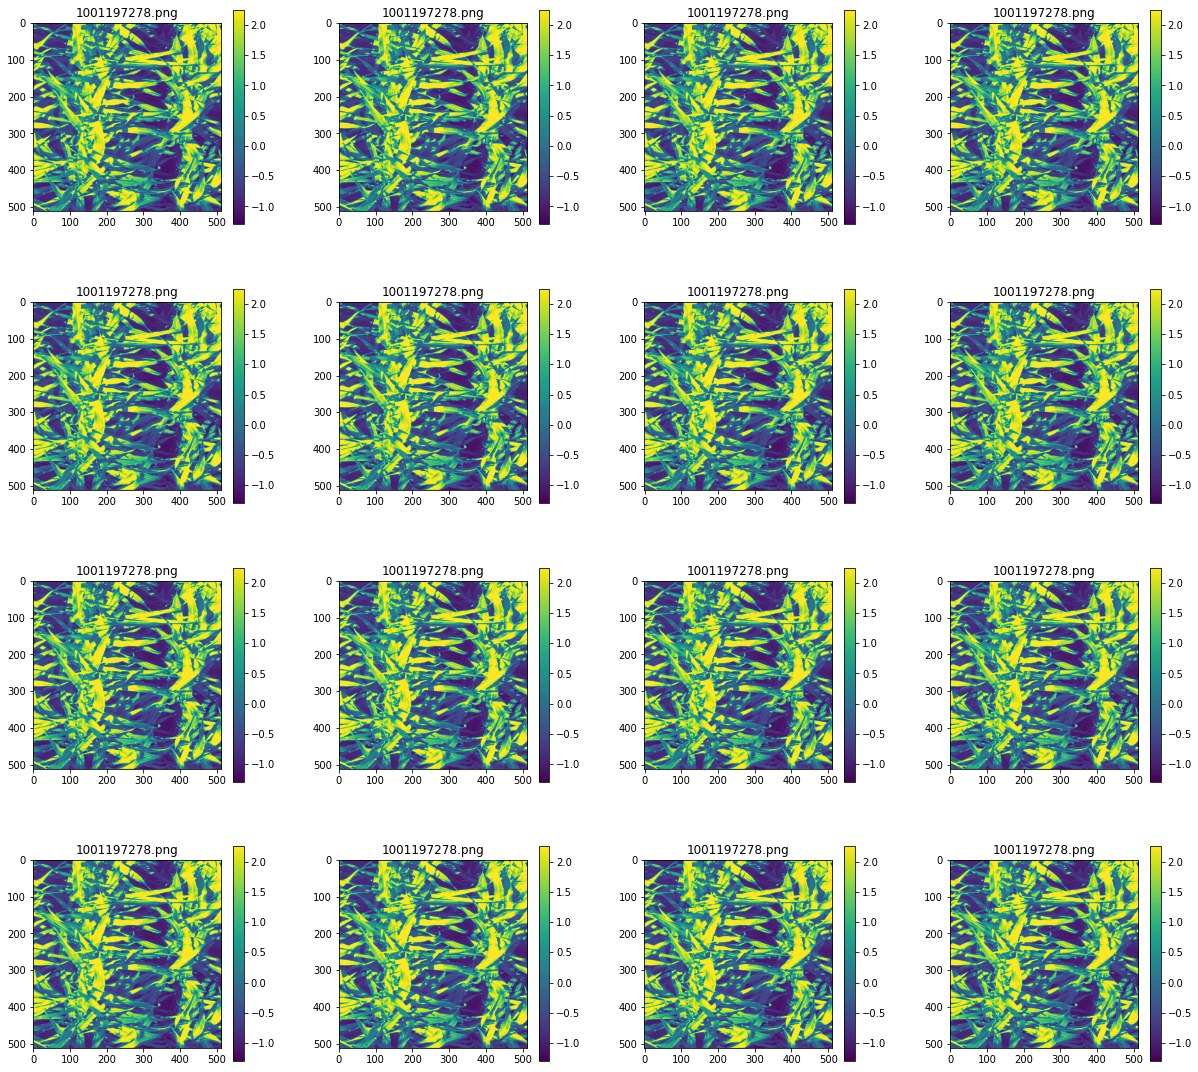

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(20, 20))
cols, rows = 4, 4
plt.subplots_adjust(left=0.13, right=0.93, top=1.0, bottom= 0.27, wspace= 0.3, hspace=0.3)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(c), size=(1,)).item()
    name, img = c[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze()[0])
    plt.colorbar()
    plt.title(name)
plt.show()


In [ ]:
from sklearn import preprocessing
import torch.nn.functional as F

data_loader = torch.utils.data.DataLoader(
    c,
    batch_size = IP.batch_size,
    num_workers = 2,
    shuffle=False,
    pin_memory = True,
    drop_last = False
)

d = {
    'filename': [],
    'cultivar': []
}

labelenc = preprocessing.LabelEncoder()
labelenc.fit(IP.universe['cultivar'].tolist())

# print(model(data_loader[0][1]))

for i, (name, image) in enumerate(data_loader):
#     if i > 1:
#         break
    
    d['filename'] += [i for i in name]
    d['cultivar'] += [i for i in labelenc.inverse_transform(F.softmax(model(image)).argmax(1))]
#     print(d)
    # d['cultivar'].append(model(image))


('1001197278.png',) tensor([[[[ 1.9064,  1.9064,  1.9064,  ...,  1.8208,  1.8208,  1.4612],
          [ 2.2489,  2.2318,  1.7865,  ...,  2.2489,  2.2489,  1.7009],
          [ 1.6495,  0.6906, -0.2513,  ...,  2.2489,  2.2489,  1.7009],
          ...,
          [-0.3541, -0.3027, -0.3369,  ..., -0.6281, -0.6623, -0.8507],
          [-0.3369, -0.3712, -0.3198,  ..., -0.6109, -0.6281, -0.8335],
          [-0.4226, -0.4739, -0.4568,  ..., -0.7479, -0.7479, -0.8849]],

         [[ 2.0784,  2.0784,  2.0784,  ...,  2.0784,  2.0784,  1.6583],
          [ 2.4286,  2.4286,  2.2360,  ...,  2.4286,  2.4286,  1.8333],
          [ 2.1134,  1.3606,  0.2052,  ...,  2.4286,  2.4286,  1.8683],
          ...,
          [-0.0399, -0.0224, -0.0224,  ..., -0.3725, -0.3550, -0.3375],
          [-0.0399, -0.0049, -0.0049,  ..., -0.3550, -0.3375, -0.3725],
          [ 0.0301,  0.0301, -0.0049,  ..., -0.3901, -0.3550, -0.3725]],

         [[ 1.5768,  2.1520,  2.2914,  ...,  0.8797,  0.9668,  0.5485],
          

In [ ]:
df = pd.DataFrame(data=d)
df.to_csv(IP.submission_path, index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d841b2e3-7f2f-42e6-ae8e-6cea1c0a3631' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>